In [5]:
import os
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras as ks
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
import cv2

seed = 1234
np.random.seed(seed)
tf.random.set_seed(seed)


In [8]:
# Set the path to the parent directory
parent_dir = 'captchas'
segmentation_dir = os.path.join(parent_dir, 'segmentation')
nonsegmentation_dir = os.path.join(parent_dir, 'nonsegmentation')
letter_dir = os.path.join(parent_dir, 'letters')
valid_extensions = [".jpg", ".jpeg", ".png", ".gif"]

# Define a function to get all the files in a directory and its subdirectories
def get_files_in_dir(dir_path, label):
    file_list = []
    for root, dirs, files in os.walk(dir_path):
        for file_name in files:
            if os.path.splitext(file_name)[1].lower() in valid_extensions:
                file_list.append((label, os.path.join(root, file_name)))
    return file_list

# Get a list of all the files in directory A and directory B
segmentation_captchas = get_files_in_dir(dir_path=segmentation_dir, label='segmentation')
letter_captchas = get_files_in_dir(dir_path=letter_dir, label='letters')
nonsegmentation_captchas = get_files_in_dir(dir_path=nonsegmentation_dir, label='nonsegmentation')

all_captchas = nonsegmentation_captchas + letter_captchas + segmentation_captchas

# Create the Pandas DataFrame
dataset = pd.DataFrame(all_captchas, columns=['label', 'img_path'])
dataset = dataset.sample(frac=1).reset_index(drop=True)

print(dataset[dataset['label'] == 'letters'])
print(dataset[dataset['label'] == 'segmentation'])
print(dataset[dataset['label'] == 'nonsegmentation'])
dataset.head()

             label                             img_path
0     segmentation  captchas/segmentation/captcha23.png
10    segmentation   captchas/segmentation/captcha8.png
93    segmentation   captchas/segmentation/captcha5.png
166   segmentation  captchas/segmentation/captcha27.png
186   segmentation  captchas/segmentation/captcha16.png
206   segmentation  captchas/segmentation/captcha13.png
226   segmentation  captchas/segmentation/captcha10.png
244   segmentation  captchas/segmentation/captcha26.png
267   segmentation  captchas/segmentation/captcha29.png
303   segmentation  captchas/segmentation/captcha17.png
326   segmentation  captchas/segmentation/captcha11.png
356   segmentation  captchas/segmentation/captcha12.png
402   segmentation   captchas/segmentation/captcha2.png
417   segmentation  captchas/segmentation/captcha25.png
491   segmentation   captchas/segmentation/captcha7.png
578   segmentation  captchas/segmentation/captcha19.png
644   segmentation  captchas/segmentation/captch

,label,img_path
0,segmentation,captchas/segmentation/captcha23.png
1,letters,captchas/letters/d22y5.png
2,letters,captchas/letters/cpe63.png
3,nonsegmentation,captchas/nonsegmentation/grid_94.jpg
4,letters,captchas/letters/p5g5m.png


(464, 462, 3)
(50, 200, 3)
(50, 200, 3)
(360, 360, 3)
(50, 200, 3)
(50, 200, 3)
(50, 200, 3)
(50, 200, 3)
(50, 200, 3)


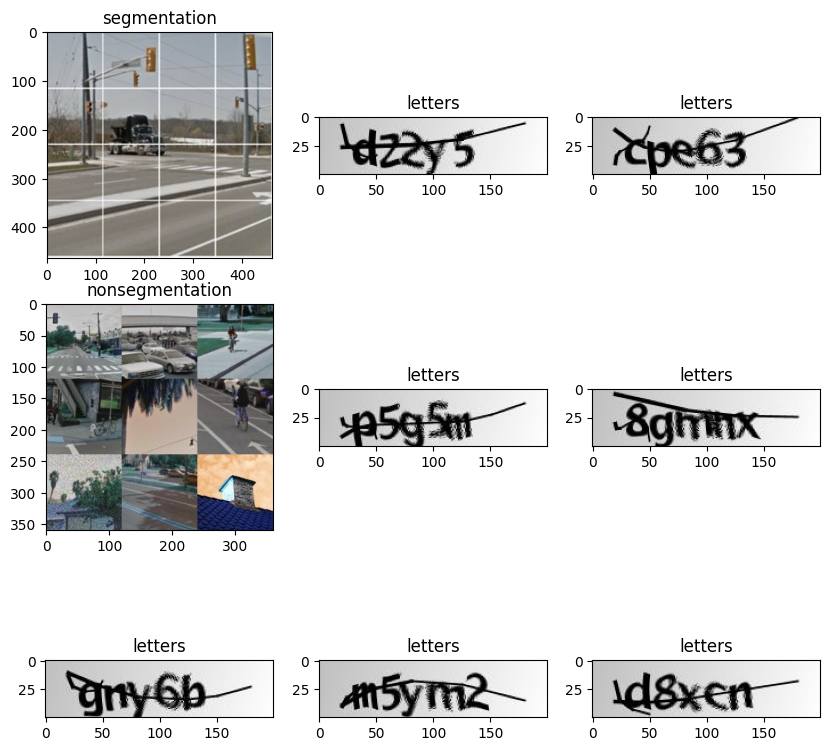

In [9]:
# Sow a sample of the images and their labels
fig, ax = plt.subplots(3, 3, figsize=(10, 10))
for i in range(3):
    for j in range(3):
        # read the image
        img = cv2.imread(dataset.iloc[i * 3 + j]["img_path"])
        print(img.shape)
        # convert to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # plot the image
        ax[i, j].imshow(img)
        # set the title
        ax[i, j].set_title(dataset.iloc[i * 3 + j]["label"])
plt.show()

In [10]:
train, test = train_test_split(dataset, test_size=0.15, random_state=seed)

train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

print("Number of training samples: ", len(train))
print("Number of validation samples: ", len(test))

Number of training samples:  1020
Number of validation samples:  180


In [11]:
class_names = dataset["label"].unique()

def encode_label(label):
    return np.argmax(label == class_names)

def decode_label(label):
    return class_names[label]

print("Class names: ", class_names)

Class names:  ['segmentation' 'letters' 'nonsegmentation']


In [12]:
def load_images_and_labels(df):
    """
    Load images and labels from a dictionary of image paths and labels.

    Parameters:
        image_dict (dict): A dictionary containing image paths and labels.

    Returns:
        A tuple containing two numpy arrays:
            - images (np.array): An array containing the loaded images in grayscale.
            - labels (np.array): An array containing the labels for each image.
    """
    # create an empty list to store the loaded images and labels
    images = []
    labels = []

    for index, row in df.iterrows():
        # load the image in grayscale
        img = cv2.imread(row['img_path'], cv2.IMREAD_COLOR)

        # resize the image to 120x120 with 3 color channels
        img = cv2.resize(img, (120, 120))

        # append the image and label to the lists
        images.append(img)
        labels.append(encode_label(row['label']))


    # convert the lists to numpy arrays
    images = np.array(images)
    labels = np.array(labels)

    # return the numpy arrays
    return images, labels

In [13]:
X_train, y_train = load_images_and_labels(train)
X_test, y_test = load_images_and_labels(test)

print("Number of training images: ", X_train.shape)
print("Number of training labels: ", y_train.shape)

print("Number of validation images: ", X_test.shape)
print("Number of validation labels: ", y_test.shape)

Number of training images:  (1020, 120, 120, 3)
Number of training labels:  (1020,)
Number of validation images:  (180, 120, 120, 3)
Number of validation labels:  (180,)


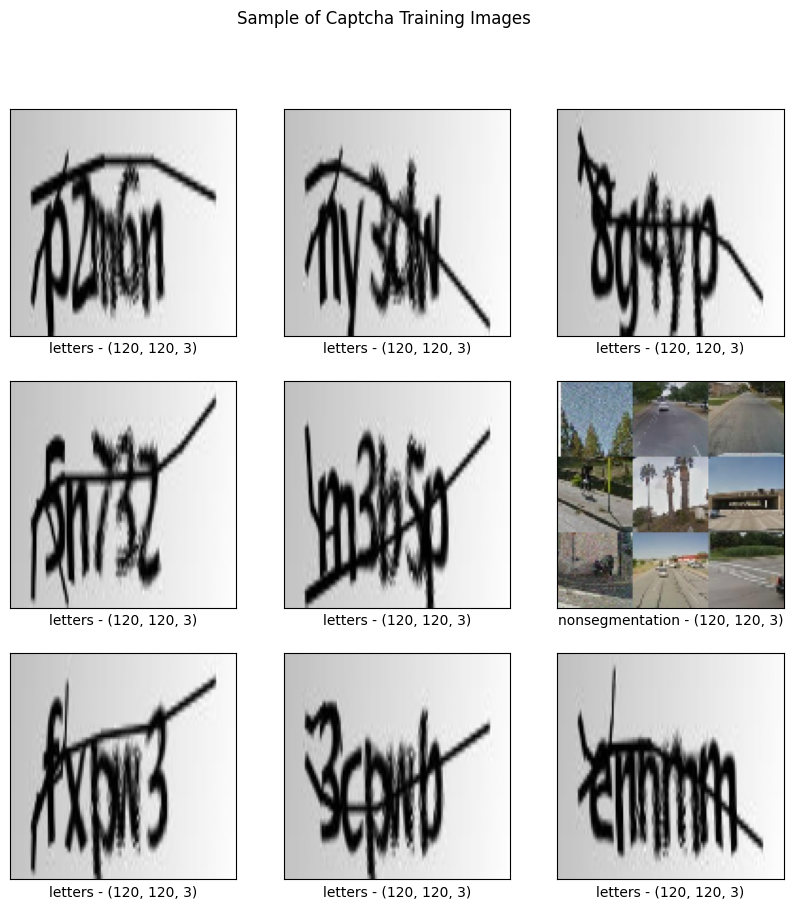

In [14]:
# Show a sample of training images and labels
plt.figure(figsize=(10, 10))

num_samples = 9
sqr = int(np.sqrt(num_samples))
indices = np.random.choice(np.arange(len(X_train)), size=num_samples, replace=False)

sample_images = X_train[indices]
sample_labels = y_train[indices]

for i in range(num_samples):
    plt.subplot(sqr, sqr, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(sample_images[i], cmap=plt.cm.binary)
    plt.xlabel(f"{decode_label(sample_labels[i])} - {sample_images[i].shape}")
plt.suptitle('Sample of Captcha Training Images')
plt.show()

In [17]:
model = ks.Sequential()
model.add(ks.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(120, 120, 3)))
model.add(ks.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(ks.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(ks.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(ks.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(ks.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(ks.layers.Flatten(input_shape=(120, 120, 3)))
model.add(ks.layers.BatchNormalization())
neurons = [256, 128, 64, 32]

for neuron in neurons:
    model.add(ks.layers.Dense(units=neuron, activation='relu'))

model.add(ks.layers.Dense(units=len(class_names), activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 118, 118, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 59, 59, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 57, 57, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 28, 28, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 26, 26, 128)       73856     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 13, 13, 128)     

In [30]:
history = model.fit(X_train, y_train,
                    batch_size=100,
                    epochs=25,
                    verbose=1,
                    validation_data=(X_test, y_test))

Epoch 1/25
11/11 [==============================] - 10s 863ms/step - loss: 1.1908e-05 - accuracy: 1.0000 - val_loss: 1.9880e-04 - val_accuracy: 1.0000
Epoch 2/25
11/11 [==============================] - 8s 733ms/step - loss: 1.4806e-05 - accuracy: 1.0000 - val_loss: 0.0015 - val_accuracy: 1.0000
Epoch 3/25
11/11 [==============================] - 8s 737ms/step - loss: 1.2417e-05 - accuracy: 1.0000 - val_loss: 0.0049 - val_accuracy: 1.0000
Epoch 4/25
11/11 [==============================] - 8s 730ms/step - loss: 1.0375e-05 - accuracy: 1.0000 - val_loss: 0.0134 - val_accuracy: 0.9944
Epoch 5/25
11/11 [==============================] - 8s 740ms/step - loss: 1.2842e-05 - accuracy: 1.0000 - val_loss: 0.0226 - val_accuracy: 0.9889
Epoch 6/25
11/11 [==============================] - 8s 734ms/step - loss: 6.0347e-06 - accuracy: 1.0000 - val_loss: 0.0326 - val_accuracy: 0.9889
Epoch 7/25
11/11 [==============================] - 8s 734ms/step - loss: 4.3722e-06 - accuracy: 1.0000 - val_loss: 0.0

1/1 [==============================] - 0s 23ms/step


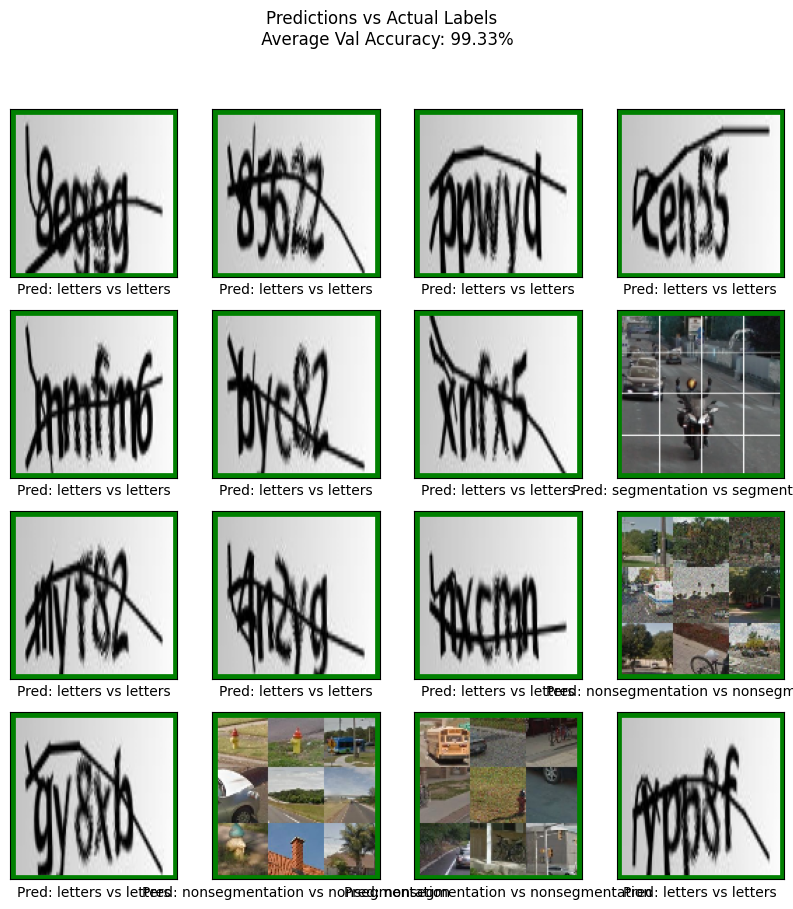

In [32]:
# Compare the predictions with the actual labels
plt.figure(figsize=(10, 10))

num_samples = 16
sqr = int(np.sqrt(num_samples))
indices = np.random.choice(np.arange(len(X_test)), size=num_samples, replace=False)

sample_images = X_test[indices]
sample_labels = y_test[indices]



for i in range(num_samples):
    plt.subplot(sqr, sqr, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(sample_images[i], cmap=plt.cm.binary)
    pred = model.predict(sample_images[i:i+1])


    pred_label = decode_label(np.argmax(pred))
    true_label = decode_label(sample_labels[i])

    plt.xlabel(f"Pred: {pred_label} vs {true_label}")

    

     # Draw a green border around the image if the prediction is correct and a red border if it is incorrect
    if pred_label == true_label:
        plt.gca().add_patch(plt.Rectangle((0, 0), 120, 120, fill=False, edgecolor='green', linewidth=7))
    else:
        plt.gca().add_patch(plt.Rectangle((0, 0), 120, 120, fill=False, edgecolor='red', linewidth=7))
average_accuracy = np.mean(history.history['val_accuracy'])
plt.suptitle(f'Predictions vs Actual Labels \n Average Val Accuracy: {average_accuracy*100:.2f}%')
plt.show()

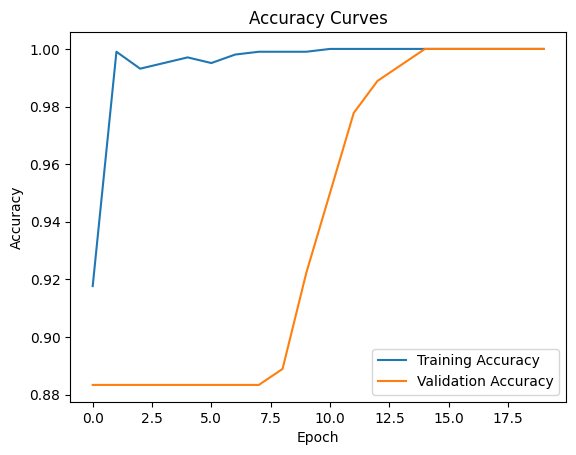

In [28]:
# Plot the accuracy curves for training and validation
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curves')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()


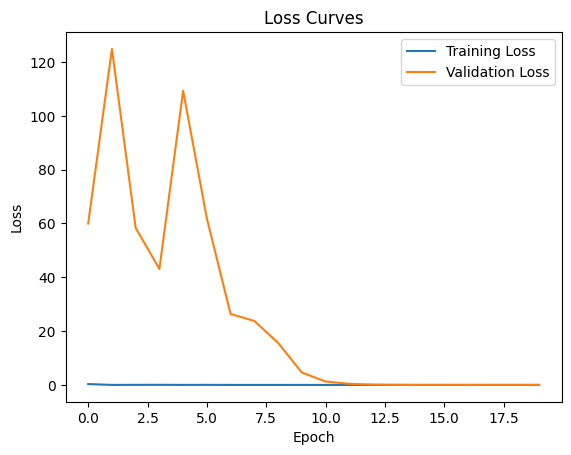

In [29]:
# Plot the loss curves for training and validation
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curves')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()



In [33]:
import pickle

# Save the model to a file
with open('captcha_type.pickle', 'wb') as file:
    pickle.dump(model, file)
